# Introduction

In my analysis, I will be exploring the following:

- Based on the reviews of the last year, what makes a good user experience at a Airbnb rental? What makes a poor user experience? What would you advise to new Airbnb hosts to ensure high reviews and consistent renters?
- What are some of the seasonal Airbnb trends you've noticed in the San Francisco area? When are the down months over the last year? Which months are the most busy? Which areas were the most popular during these times? How have prices changed over time?
- Are airbnb's that are available for monthly rent competitive with the local markets?
- Can you create a price predictor for listings price? What features allows renters to charge more?

In [74]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [75]:
#Set pandas backend to create interactive plots
#pd.options.plotting.backend = 'hvplot'

#Whats the defailt back end? Not all plots work with this

In [76]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)
plt.style.use('fivethirtyeight')


#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Ignore warnings
import warnings; warnings.simplefilter('ignore')

**Read in Data**

In [77]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

In [78]:
#Read in Zillow data
zillow = pd.read_csv(path + '12_23_2019_Zillow_Cleaned.csv', index_col=0, sep=',')

#Read in Airbnb Listings Data
listings = pd.read_csv(path + '12_27_2019_Listings_Cleaned.csv',index_col=0, low_memory=False, sep=',')

#Parse dates
parse_dates = ['date']

#Read in Airbnb Calendar and Reviews data
calendar = pd.read_csv(path + '12_23_2019_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=parse_dates,index_col=0, low_memory=False)

reviews = pd.read_csv(path + '12_24_2019_Reviews_Cleaned.csv', sep=',',
                      parse_dates=parse_dates,index_col=0)


# Data Preview

**Airbnb Listings Data**

In [79]:
display(listings.head())

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,space,summary,transit,zipcode,weekly_price,monthly_price
0,3,TV Cable TV Internet Wifi Kitchen Pets liv...,0,77,1.0,Real Bed,1.0,2.0,1,0.0,0.0,2019-04-03 00:00:00.000000,NaN,moderate,San Francisco,100.0,New update: the house next door is under const...,25.0,2009-07-23 00:00:00.000000,2,We are a family with 2 boys born in 2009 and 2...,True,1169,True,True,1.0,"San Francisco, California, United States",Holly,Duboce Triangle,100.0,within an hour,2008-07-31 00:00:00.000000,email phone facebook reviews kba,* No Pets - even visiting guests for a short t...,958,True,True,2019-03-16 00:00:00.000000,37.76931,-122.43386,30.0,"Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,183,51.0,170.0,Apartment,False,False,True,10.0,10.0,10.0,10.0,10.0,97.0,10.0,1.55,Entire home/apt,2.019040e+13,100.0,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,94117.0,1120.0,4200.0
1,5,Internet Wifi Kitchen Heating Family/kid fri...,0,0,1.0,Real Bed,2.0,3.0,1,0.0,0.0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,100.0,We live in a large Victorian house on a quiet ...,0.0,2009-05-03 00:00:00.000000,2,Philip: English transplant to the Bay Area and...,True,8904,True,False,2.0,"San Francisco, California, United States",Philip And Tania,Bernal Heights,80.0,within a day,2009-03-02 00:00:00.000000,email phone reviews kba work_ema...,"Please respect the house, the art work, the fu...",5858,False,True,2017-08-06 00:00:00.000000,37.74511,-122.42102,60.0,Creative Sanctuary,I love how our neighborhood feels quiet but is...,Bernal Heights,111,0.0,235.0,Apartment,False,False,True,10.0,10.0,10.0,10.0,10.0,98.0,9.0,0.92,Entire home/apt,2.019040e+13,NaN,We live in a large Victorian house on a quiet ...,NaN,The train is two blocks away and you can stop ...,94110.0,1600.0,5500.0
2,2,TV Internet Wifi Kitchen Free street parking...,30,365,4.0,Real Bed,1.0,1.0,9,9.0,0.0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,50.0,Nice and good public transportation. 7 minute...,12.0,2009-08-31 00:00:00.000000,1,7 minutes walk to UCSF. 15 minutes walk to US...,True,21994,True,False,10.0,"San Francisco, California, United States",Aaron,Cole Valley,100.0,within a few hours,2009-06-17 00:00:00.000000,email phone reviews jumio govern...,"No party, No smoking, not for any kinds of smo...",7918,False,True,2016-11-21 00:00:00.000000,37.76669,-122.45250,60.0,A Friendly Room - UCSF/USF - San Francisco,"Shopping old town, restaurants, McDonald, Whol...",Haight Ashbury,17,0.0,65.0,Apartment,False,False,True,8.0,9.0,8.0,9.0,9.0,85.0,8.0,0.15,Private room,2.019040e+13,200.0,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,94117.0,485.0,1685.0
3,2,TV Internet Wifi 

**Airbnb Reviews Data**

In [80]:
display(reviews.head())

,comments,date,id,listing_id,reviewer_id,reviewer_name
19330,...,2013-12-01,9000494,209514,9215434,Ramon
143113,Stop and book it now Rea Website hidd...,2017-06-07,158659946,4833101,35954713,Tim
3597188,So I moved to SF in late May from Mich...,2013-06-02,4928809,635850,6542011,Michael
64636,This was the perfect home from home ou...,2014-10-16,21374058,1150867,13431837,Chris & Tess
174143,We loved our time in beautiful SF The p...,2018-08-10,305042501,7226841,73281468,Jessica ( + Mark)


**Airbnb Calendar Data**

In [81]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,80.0,0,2019-04-03,187730,120.0,3.0,80.0
1,80.0,0,2019-04-04,187730,120.0,3.0,80.0
2,82.0,1,2019-04-05,187730,120.0,3.0,82.0
3,82.0,1,2019-04-06,187730,120.0,3.0,82.0
4,81.0,1,2019-04-07,187730,120.0,3.0,81.0


**Zillow Data**

In [82]:
display(zillow.head())

,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price_SqrFt
0,10025.0,New York,NY,New York-Newark-Jersey City,New York County,1.0,2010-02-01,NaN
1,10023.0,New York,NY,New York-Newark-Jersey City,New York County,2.0,2010-02-01,NaN
2,77494.0,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,3.0,2010-02-01,NaN
3,77449.0,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4.0,2010-02-01,NaN
4,77084.0,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,5.0,2010-02-01,NaN


Capture Zillow data pertaining to data in listings data

In [83]:
#Capture zip information from listings
listings_zip = list(listings.zipcode.unique())

#Capture city information from listings 
listings_cities = ['Brisbane', 'Daly City', 'San Francisco', 'South San Francisco']

#Capture SF Data
sf_zillow = zillow[zillow['RegionName'].isin(listings_zip) | zillow['City'].isin(listings_cities)]

#Check
sf_zillow

,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price_SqrFt
7,94109.0,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,8.0,2010-02-01,NaN
68,94110.0,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,69.0,2010-02-01,NaN
423,94080.0,South San Francisco,CA,San Francisco-Oakland-Hayward,San Mateo County,424.0,2010-02-01,NaN
451,94112.0,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,452.0,2010-02-01,NaN
538,94015.0,Daly City,CA,San Francisco-Oakland-Hayward,San Mateo County,539.0,2010-02-01,NaN
...,...,...,...,...,...,...,...,...
775930,94123.0,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,1555.0,2019-10-01,4.808244
776224,94131.0,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,1849.0,2019-10-01,3.846154
776628,94510.0,Benicia,CA,Vallejo-Fairfield,Solano County,2253.0,2019-10-01,1.954972
777350,94105.0,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,2975.0,2019-10-01,5.211640


# Data Exploration

- Based on the reviews of the last year, what makes a good user experience at a Airbnb rental? What makes a poor user experience? What would you advise to new Airbnb hosts to ensure high reviews and consistent renters?
- What are some of the seasonal Airbnb trends you've noticed in the San Francisco area? When are the down months over the last year? Which months are the most busy? Which areas were the most popular during these times? How have prices changed over time?
- How has Airbnb grown over the last year? What kinds of properties are able to charge more
- Are airbnb's that are available for monthly rent competitive with the local markets? 
- Can you create a price predictor for listings price? What features allows renters to charge more?

### How has Airbnb grown over the last year(11/2018 - 10/2019)?

In [84]:
#Filter calendar to show listings from nov 2018 - oct 2019 and store in a df
last_year=calendar[(calendar['date'] < '2019-11-01')]

#Extract month and year from date. Store as month_year
last_year['month_year'] = pd.to_datetime(calendar['date']).dt.to_period('M')

#Group last year by month_year and get a count of unique listings per month
last_year = last_year.groupby(['month_year'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
last_year =last_year.rename(columns = {'nunique': 'listings'})

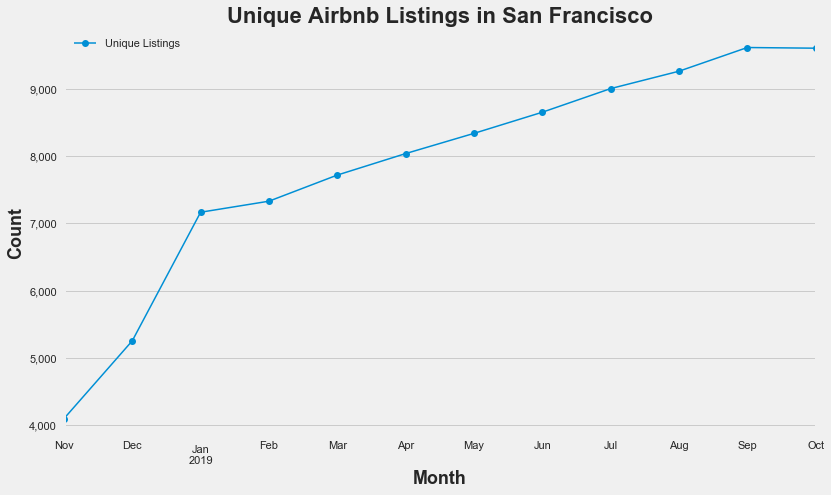

In [85]:
#Plot data
ax = last_year.plot(x='month_year', y='listings', kind = 'line',style='o-', markersize=7,
          title='Unique Airbnb Listings in San Francisco', label= 'Unique Listings',
         linewidth = 1.5, figsize = (12,7))

#Set fontdict
fontdict={'weight' : 'bold',
        'size'   : 18}

#Set x and y labels
ax.set_xlabel('Month',fontdict=fontdict)
ax.set_ylabel('Count', fontdict=fontdict)

#Format yticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

#Set Title
ax.set_title('Unique Airbnb Listings in San Francisco', fontweight = 'bold', fontsize=22)

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

In [87]:
#rent using sqrft comapring airbnb vs zillow. Is airbnb a better option than renting space for transplants

listings.head(3)

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,space,summary,transit,zipcode,weekly_price,monthly_price
0,3,TV Cable TV Internet Wifi Kitchen Pets liv...,0,77,1.0,Real Bed,1.0,2.0,1,0.0,0.0,2019-04-03 00:00:00.000000,NaN,moderate,San Francisco,100.0,New update: the house next door is under const...,25.0,2009-07-23 00:00:00.000000,2,We are a family with 2 boys born in 2009 and 2...,True,1169,True,True,1.0,"San Francisco, California, United States",Holly,Duboce Triangle,100.0,within an hour,2008-07-31 00:00:00.000000,email phone facebook reviews kba,* No Pets - even visiting guests for a short t...,958,True,True,2019-03-16 00:00:00.000000,37.76931,-122.43386,30.0,"Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,183,51.0,170.0,Apartment,False,False,True,10.0,10.0,10.0,10.0,10.0,97.0,10.0,1.55,Entire home/apt,2.019040e+13,100.0,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,94117.0,1120.0,4200.0
1,5,Internet Wifi Kitchen Heating Family/kid fri...,0,0,1.0,Real Bed,2.0,3.0,1,0.0,0.0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,100.0,We live in a large Victorian house on a quiet ...,0.0,2009-05-03 00:00:00.000000,2,Philip: English transplant to the Bay Area and...,True,8904,True,False,2.0,"San Francisco, California, United States",Philip And Tania,Bernal Heights,80.0,within a day,2009-03-02 00:00:00.000000,email phone reviews kba work_ema...,"Please respect the house, the art work, the fu...",5858,False,True,2017-08-06 00:00:00.000000,37.74511,-122.42102,60.0,Creative Sanctuary,I love how our neighborhood feels quiet but is...,Bernal Heights,111,0.0,235.0,Apartment,False,False,True,10.0,10.0,10.0,10.0,10.0,98.0,9.0,0.92,Entire home/apt,2.019040e+13,NaN,We live in a large Victorian house on a quiet ...,NaN,The train is two blocks away and you can stop ...,94110.0,1600.0,5500.0
2,2,TV Internet Wifi Kitchen Free street parking...,30,365,4.0,Real Bed,1.0,1.0,9,9.0,0.0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,50.0,Nice and good public transportation. 7 minute...,12.0,2009-08-31 00:00:00.000000,1,7 minutes walk to UCSF. 15 minutes walk to US...,True,21994,True,False,10.0,"San Francisco, California, United States",Aaron,Cole Valley,100.0,within a few hours,2009-06-17 00:00:00.000000,email phone reviews jumio govern...,"No party, No smoking, not for any kinds of smo...",7918,False,True,2016-11-21 00:00:00.000000,37.76669,-122.45250,60.0,A Friendly Room - UCSF/USF - San Francisco,"Shopping old town, restaurants, McDonald, Whol...",Haight Ashbury,17,0.0,65.0,Apartment,False,False,True,8.0,9.0,8.0,9.0,9.0,85.0,8.0,0.15,Private room,2.019040e+13,200.0,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,94117.0,485.0,1685.0


Distributions of target variable: Price

**Prices by property type**

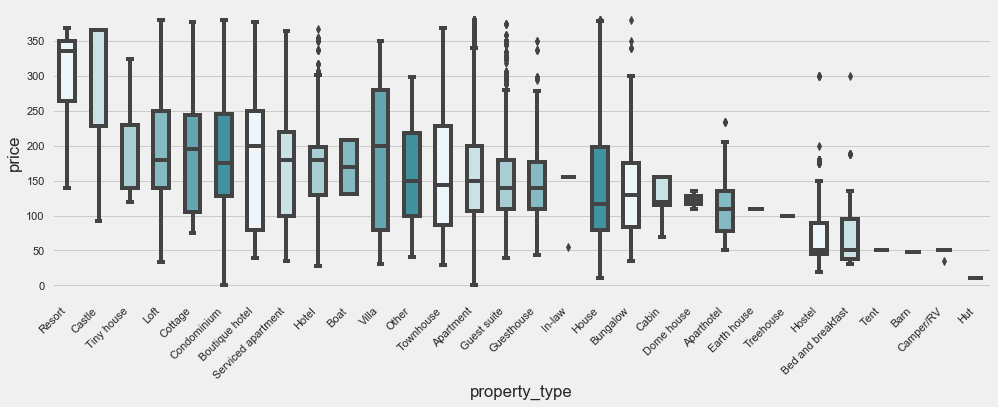

In [98]:
test = listings.groupby('property_type')['price'].mean().sort_values(ascending = False).reset_index()
test_list = test.property_type.tolist()

#Set Figure
f, ax = plt.subplots(figsize= (15,5))

#Plot
g= sns.boxplot(x="property_type", y="price", order=test_list, 
               width = .5,palette=sns.light_palette((210, 90, 60), input="husl"),
             data=listings, ax=ax)

#Rotate x_ticklabels
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

**Average prices by neighborhood**

In [ ]:
#Create df to plot average price by neighborhood
neighborhood = listings.groupby(
    'neighbourhood_cleansed')['price'].mean().reset_index().sort_values(
                                            by='price', ascending=False)

#Set fig dimensions
f, ax = plt.subplots(figsize= (5,13))

#plot
g= sns.barplot(x='price', y='neighbourhood_cleansed', color='g',
              data=neighborhood, ax=ax)

#Set plot Title
g.set_title('Price per Night')

#Add mean
plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

#Set plot labels
g.set_xlabel('test')
g.set_ylabel('test')

Comparing monthly rent of airbnb to zillow

Prices accross San Francisco

In [ ]:
# neighborhood.plot(kind='scatter', x="longitude", y="latitude",c='price', 
#           cmap=plt.get_cmap("jet"),label = 'Price', 
#     colorbar=True, alpha=0.8, figsize=(10,10))
# plt.legend()
# plt.show()


**Heat map**

In [ ]:
# corr = listings.corr()
# plt.figure(figsize=(15, 15))
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,linewidths=.1,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

In [ ]:
# #Print correlations to price
# df[df.columns[1:]].corr()['price'][:].sort_values(ascending =False)

### Principal Component Analysis

Text Analysis

Some questions to explore:
- What are the topics of negative reviews vs positive reviews?
- Does greater word usage correlate positively with a more negative experience?
- How would you advise first time hosts to increase the liklihood of a positive review?
